# **Task 1:**

### Building a CNN-LSTM model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
maxlen = 500
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=10000, output_dim=128, input_length=maxlen)(inputs)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(128)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))


Epoch 1/5
196/196 [==============================] - 218s 1s/step - loss: 0.4107 - accuracy: 0.7966 - val_loss: 0.2968 - val_accuracy: 0.8788
Epoch 2/5
196/196 [==============================] - 246s 1s/step - loss: 0.1980 - accuracy: 0.9278 - val_loss: 0.2820 - val_accuracy: 0.8822
Epoch 3/5
196/196 [==============================] - 257s 1s/step - loss: 0.1284 - accuracy: 0.9572 - val_loss: 0.3496 - val_accuracy: 0.8704
Epoch 4/5
196/196 [==============================] - 256s 1s/step - loss: 0.0733 - accuracy: 0.9780 - val_loss: 0.3801 - val_accuracy: 0.8773
Epoch 5/5
196/196 [==============================] - 245s 1s/step - loss: 0.0452 - accuracy: 0.9874 - val_loss: 0.4797 - val_accuracy: 0.8741


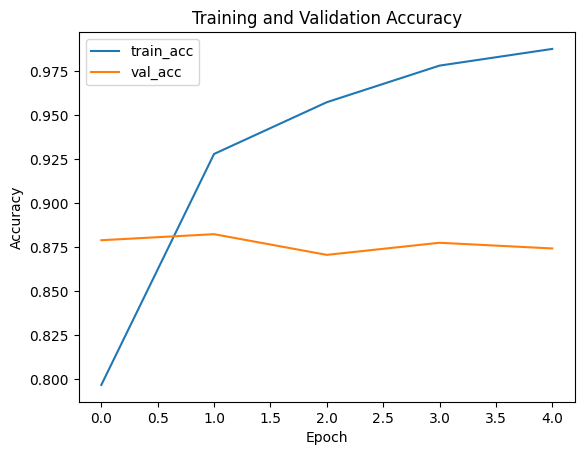

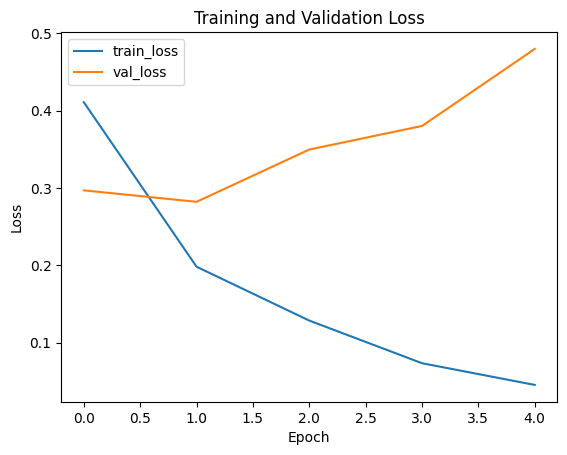

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
label_prediction = model.predict(x_test)
label_prediction = np.round(label_prediction).flatten()
conf_matrix = confusion_matrix(y_test, label_prediction)
print(conf_matrix)


782/782 [==============================] - 75s 95ms/step
[[11047  1453]
 [ 1695 10805]]


In [ ]:
sign_flag = imdb.get_word_index()
sign_flag = {k:(v+3) for k,v in sign_flag.items()}
sign_flag['<PAD>'] = 0
sign_flag['<START>'] = 1
sign_flag['<UNK>'] = 2
reverse_sign_flag = {v:k for k,v in sign_flag.items()}

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
correct_indices = np.where((y_test == label_prediction))[0]
print("Here are some correctly classified reviews:")
for i in range(3):
    index = np.random.choice(correct_indices)
    review = [reverse_sign_flag.get(i, '?') for i in x_test[index] if i != 0] 
    print("Review:\n", ' '.join(review))
    print("True label:", y_test[index], "Predicted label:", label_prediction[index], "\n")

incorrect_indices = np.where((y_test != label_prediction))[0]
print("Here are some incorrectly classified reviews:")
for i in range(3):
    index = np.random.choice(incorrect_indices)
    review = [reverse_sign_flag.get(i, '?') for i in x_test[index] if i != 0] 
    print("Review:\n", ' '.join(review))
    print("True label:", y_test[index], "Predicted label:", label_prediction[index], "\n")


Here are some correctly classified reviews:
Review:
 the blood of <UNK> <UNK> meanwhile <UNK> falls for a guy named <UNK> michael watson who just so happens to be brother <UNK> <UNK> decide to team up rid the world of the evil br br directed by ted this film seems to be quite highly regarded amongst genre fans while it's not terrible i certainly wouldn't call it very good i <UNK> really see anything much to get excited about <UNK> is a rather slow going film not that much actually happens while it does try to stay close to certain classic vampire <UNK> there's all this nonsense about a some little monsters that grow from the <UNK> of severed fingers for some reason <UNK> could have been a half decent film if not for the fact that it's dull i really can't remember that much about it good or bad the character's are alright but some f the dialogue is silly there's a scene which <UNK> me near the start when the girls are at the castle ruins one says they have to go because it's getting dar

#### By fine-tuning the model architecture, experimenting with different embedding dimensions, and adjusting hyperparameters such as dropout rate, learning rate, and the number of training epochs, it's possible to improve the accuracy to 90+% on the IMDB movie review sentiment classification dataset.

# **Task 2:**

### Building a seq2seq model

In [ ]:
import tensorflow_datasets as tfds
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.layers import LSTM, GRU, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
datasets = tfds.load('ted_multi_translate', split=['train', 'validation'])

train_set = datasets[0]
val_set = datasets[1]

max_inp_len = 100
max_out_len = 100

In [ ]:
train_inp_texts = []
train_out_texts = []
for entry in train_set:
    lang_vals = [val.decode('utf-8') for val in entry['translations']['language'].numpy()]
    if 'fr' in lang_vals:
        fr_idx = lang_vals.index('fr')
        en_idx = lang_vals.index('en')
        train_inp_texts.append(entry['translations']['translation'][en_idx].numpy().decode('utf-8'))
        train_out_texts.append(entry['translations']['translation'][fr_idx].numpy().decode('utf-8'))

val_inp_texts = []
val_out_texts = []
for entry in val_set:
    lang_vals = [val.decode('utf-8') for val in entry['translations']['language'].numpy()]
    if 'fr' in lang_vals:
        fr_idx = lang_vals.index('fr')
        en_idx = lang_vals.index('en')
        val_inp_texts.append(entry['translations']['translation'][en_idx].numpy().decode('utf-8'))
        val_out_texts.append(entry['translations']['translation'][fr_idx].numpy().decode('utf-8'))

In [ ]:
def tokenize_text(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer.texts_to_sequences(texts), tokenizer

special_punctuation = string.punctuation + "¡" + '¿'
def preprocess_text(text):
    processed_text = text.lower().translate(str.maketrans('', '', special_punctuation))
    return processed_text

inp_sentences = [preprocess_text(text) for text in train_inp_texts]
out_sentences = [preprocess_text(text) for text in train_out_texts]

tokenized_out_texts, out_tokenizer = tokenize_text(out_sentences)
tokenized_inp_texts, inp_tokenizer = tokenize_text(inp_sentences)

out_vocab_size = len(out_tokenizer.word_index) + 1
inp_vocab_size = len(inp_tokenizer.word_index) + 1

In [ ]:
out_padded_texts = pad_sequences(tokenized_out_texts, max_out_len, padding="post")
inp_padded_texts = pad_sequences(tokenized_inp_texts, max_inp_len, padding="post")

out_padded_texts = out_padded_texts.reshape(*out_padded_texts.shape, 1)
inp_padded_texts = inp_padded_texts.reshape(*inp_padded_texts.shape, 1)

In [ ]:
input_seq = Input(shape=(max_inp_len,))
embed_layer = Embedding(input_dim=inp_vocab_size, output_dim=256)(input_seq)
enc_layer = GRU(64, return_sequences=False)(embed_layer)
rep_vector = RepeatVector(max_out_len)(enc_layer)
dec_layer = GRU(64, return_sequences=True, dropout=0.3)(rep_vector)
dense_layer = Dense(out_vocab_size)
logit_layer = TimeDistributed(dense_layer)(dec_layer)

In [ ]:
model = Model(input_seq, Activation('softmax')(logit_layer))
model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(1e-3), metrics=['accuracy'])
history = model.fit(inp_padded_texts, out_padded_texts, batch_size=32, epochs=5)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Epoch 1/5
 735/6010 [==>...........................] - ETA: 11:10:58 - loss: 1.5862 - accuracy: 0.8080